In [6]:
! pip install -q kaggle

In [7]:
! cp /content/kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

In [ ]:
!unzip /content/creditcardfraud.zip

In [235]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)


In [178]:
data = pd.read_csv("/content/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [179]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [299]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [181]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(X)

In [182]:
X_t.shape, Y.shape

((1492, 2), (1492,))

In [183]:
df['TSNE-one'] = X_t[:,0]
df['TSNE-two'] = X_t[:,1]

<Axes: xlabel='TSNE-one', ylabel='TSNE-two'>

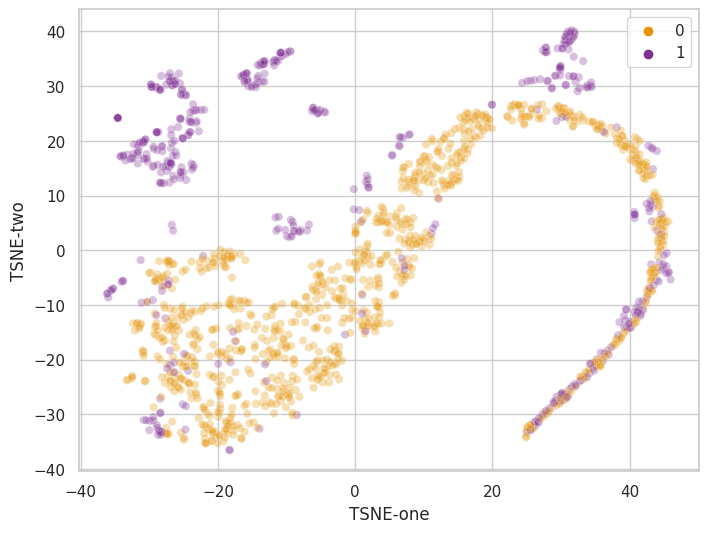

In [212]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="TSNE-one", y="TSNE-two",
    hue= Y,
    palette=sns.color_palette("CMRmap_r", 2),
    data=df,
    legend="full",
    alpha=0.3
)

# AutoEncoders

***What are Autoencoders?*** - Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.


---

![](https://i.imgur.com/Rrmaise.png)    


---
We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package.




In [213]:
## input layer
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [214]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [215]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [ ]:
# We will use only 2000 rows of non fraud cases to train the autoencoder.
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 128, epochs = 50,
                shuffle = True, validation_split = 0.20)

## Obtain the Latent Representations


In [217]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [218]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 1ms/step


# Visualize the latent representations : Fraud Vs Non Fraud


In [219]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

# Simple Linear Classifier


In [222]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)


In [247]:
def scores(val_y, pred_y):
  print ("")
  print ("Classification Report: ")
  print (classification_report(val_y, pred_y))

  print ("")
  print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

In [ ]:
#logistic Regression

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
scores(val_y, pred_y)

In [ ]:
#DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [ ]:
#GaussianNB

clf = GaussianNB().fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [ ]:
#XGBoost

clf = xgb.XGBClassifier().fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [ ]:
#LightGBM

clf = lgb.LGBMClassifier().fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [ ]:
#KNeighborsClassifier

clf = KNeighborsClassifier().fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [ ]:
#Support Vector Classifier

clf = SVC().fit(train_x, train_y)
pred_y = clf.predict(val_x)
(val_y, pred_y)

In [250]:
from sklearn.ensemble import VotingClassifier

In [257]:
# create a voting classifier with hard voting

voting_classifier_hard = VotingClassifier(
    estimators = [('lr', LogisticRegression()),
                  ('dtc', DecisionTreeClassifier(random_state=42)),
                  ('gnb', GaussianNB()),
                  ('xgb', xgb.XGBClassifier()),
                  ('lgb',  lgb.LGBMClassifier()),
                  ('KNC', KNeighborsClassifier()),
                  ('SVC', SVC(probability=True)),
                  ],
    voting='hard')

# create a voting classifier with hard voting
voting_classifier_soft = VotingClassifier(
    estimators = [('lr', LogisticRegression()),
                  ('dtc', DecisionTreeClassifier(random_state=42)),
                  ('gnb', GaussianNB()),
                  ('xgb', xgb.XGBClassifier()),
                  ('lgb',  lgb.LGBMClassifier()),
                  ('KNC', KNeighborsClassifier()),
                  ('SVC', SVC(probability=True)),
                  ],
    voting='soft')


In [258]:
# make predictions with the hard voting model
voting_classifier_hard.fit(train_x, train_y)
y_pred_vch = voting_classifier_hard.predict(val_x)


In [259]:
# make predictions with the soft voting model
voting_classifier_soft.fit(train_x, train_y)
y_pred_vcs = voting_classifier_soft.predict(val_x)

In [270]:
# evaluate both models with the classification_report
print("The hard voting model\n")
f1_vch = scores(val_y, y_pred_vch)
print("")
print("The soft voting model\n")
f1_vcs = scores(val_y, y_pred_vcs)

The hard voting model


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       772
         1.0       1.00      0.99      1.00       101

    accuracy                           1.00       873
   macro avg       1.00      1.00      1.00       873
weighted avg       1.00      1.00      1.00       873


Accuracy Score:  0.9988545246277205

The soft voting model


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       772
         1.0       1.00      0.99      1.00       101

    accuracy                           1.00       873
   macro avg       1.00      1.00      1.00       873
weighted avg       1.00      1.00      1.00       873


Accuracy Score:  0.9988545246277205




---



---



In [313]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)

    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=5,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=5,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    # plt.show

In [ ]:
tsne_scatter(X, Y, dimensions=2, save_as='Originaal.png')

In [ ]:
tsne_scatter(rep_x, rep_y, dimensions=2, save_as='representation_autoencoder.png')
#latent autoencoder representation